In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline   
import seaborn as sns
import warnings
import matplotlib as mpl


from scipy import stats
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from skrebate import ReliefF
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from rdea.filters.mrmr import MRMRP
from rdea.utils.help_functions import model_based_relevance, auc_relevance, load_DEGs

# Set random seed
seed = 7
np.random.seed(seed)
pca = PCA(0.95)

In [2]:
# in and out files
data_file = './data/GSE66099.csv'
degs_file = './data/GSE66099_DEGs.txt'
out_file = './results/sepsis/fs_scores.csv'
is_save_results = True

# data pre-processing
norm_filter = MinMaxScaler()

# experiment
num_folds = 10
num_runs = 10
label = 'Died'

# num feature selection
num_features = 10

# classifier
model = SGDClassifier(loss="log", penalty="l2", random_state=seed)

top_markers_to_viz = 10      #set num marker gene

#Load 108 DEGs
if degs_file is not None:
    DEGs = load_DEGs(degs_file)
    print('{} DEGs loaded!'.format(len(DEGs)))
else:
    print('No DEGs provided. Pipeline will consider all genes.')


108 DEGs loaded!


In [3]:
# Load and Normalize data

df = pd.read_csv(data_file)
print('Shape of {0} is {1}'.format(data_file, df.shape))
y = df[label]
if degs_file is not None:
    df = df[DEGs]
else:
    df =df.drop([label],axis=1)
names = df.columns
X = df.values

# normalize data via column
X = norm_filter.fit_transform(X, y)
print('Genes Normalized..')
print(len(X[0]))
print(len(y))
df

Shape of ./data/GSE66099.csv is (199, 10603)
Genes Normalized..
108
199


,SLC39A8,RHAG,DDIT4,MPO,RRM2,CCL3,MAFF,TYMS,ENPP2,KIAA0101,...,CD302,NUAK2,RCBTB2,EMR3,HSPA6,FGL2,RGS2,CPVL,CCR2,TGFBI
0,7.837760,4.112866,8.046405,2.324069,4.759059,3.140721,8.578116,5.230842,3.862937,5.590981,...,8.448658,7.988770,8.358142,2.135084,9.884938,11.812192,8.859253,5.722329,7.817754,4.143039
1,7.751983,1.485795,8.971049,5.258546,7.684430,2.811141,4.715507,7.567845,3.212268,6.279265,...,8.094179,7.694309,7.057639,1.673705,8.728279,9.303093,10.367759,6.251313,8.707475,4.977650
2,10.279053,1.925620,8.712714,1.856427,5.890788,5.947866,9.109963,6.066830,3.086101,4.688248,...,6.664949,6.276276,5.362376,1.706595,8.115265,11.027659,8.161037,2.841639,2.932313,4.036440
3,9.601609,5.888388,8.527441,5.750055,8.206514,5.134266,5.156271,8.057016,2.684719,7.520501,...,9.473646,7.701587,6.420084,1.464756,9.028702,9.271985,9.948187,6.095365,8.859346,4.616064
4,7.785195,4.846312,9.301229,8.695507,10.032503,6.555199,8.041716,9.813448,7.125344,7.953979,...,6.593451,8.225254,7.090539,1.704964,7.833078,10.653802,8.848570,4.970816,5.720992,6.542890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,7.181331,2.365467,8.184828,6.181315,7.871825,2.929050,4.431776,7.034406,3.780909,6.776981,...,10.070218,8.961620,9.165776,4.359999,9.826060,12.136311,11.699008,8.973876,10.186479,7.998090
195,5.251613,2.714796,6.427088,3.523980,7.221401,2.154800,7.541867,7.252205,2.629904,5.149909,...,7.966326,10.124670,8.929071,5.286965,11.191417,10.300791,12.054893,5.030908,7.810187,4.979873
196,5.905524,8.074482,6.259182,2.492298,5.146876,1.794615,8.769124,4.142922,2.246056,3.771786,...,8.859861,8.749832,7.340047,3.792716,9.980401,10.117659,11.990752,8.142582,9.141700,8.446067
197,4.786756,2.279402,5.955421,8.199064,8.008226,3.352024,5.653967,7.454457,2.954322,6.091752,...,9.900709,9.382461,8.536407,6.077819,10.639624,11.693861,12.093385,8.897881,8.854635,9.477510


In [4]:
# from sklearn.preprocessing import StandardScaler
# df = StandardScaler().fit_transform(df)

In [5]:
#apply PCA
results = pca.fit_transform(X)
results.shape

(199, 40)

In [6]:
from sklearn import svm
clf = svm.SVC()

In [7]:
#apply Lasso degenerate the parameters
from sklearn.linear_model import Lasso

lass = Lasso(
    max_iter=3000,
    alpha= 0.00281,
    random_state= 5,
)
lass.fit(df,y)
lass.coef_.min(), lass.coef_.max()


(-0.1685062251092727, 0.12653718629752864)

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

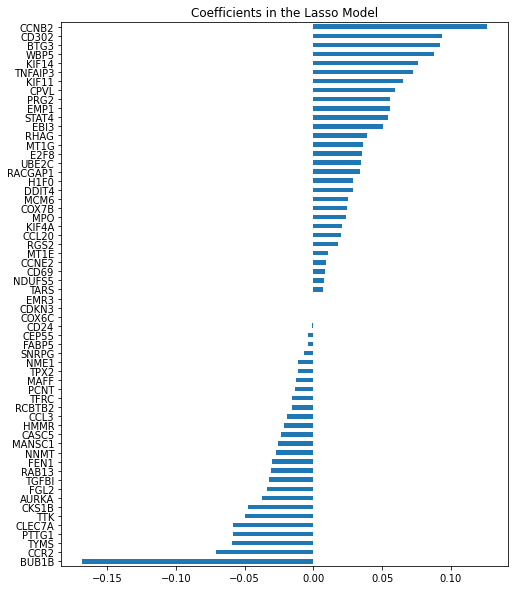

In [8]:
#lass feature importances
coef = pd.Series(lass.coef_, index = df.columns)
imp_coef = pd.concat([coef.sort_values().head(30),
                     coef.sort_values().tail(30)])
mpl.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [10]:
good_feats = np.abs(np.array(lass.coef_)) > 0
print("Features reduced from %10d to %10d" % (df.shape[1], int(good_feats.sum())))

Features reduced from        108 to         66


In [11]:
train_lasso_select = df.iloc[:, good_feats]
train_lasso_select.to_csv('train_lasso_select.csv',index=False)


In [12]:
# Using xgboost to plot importance
from xgboost import XGBClassifier,plot_importance
model = XGBClassifier(max_depth=5,n_estimators=1000,learning_rate=1e-2)
model.fit(df,y)

C:\Users\vuduc\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

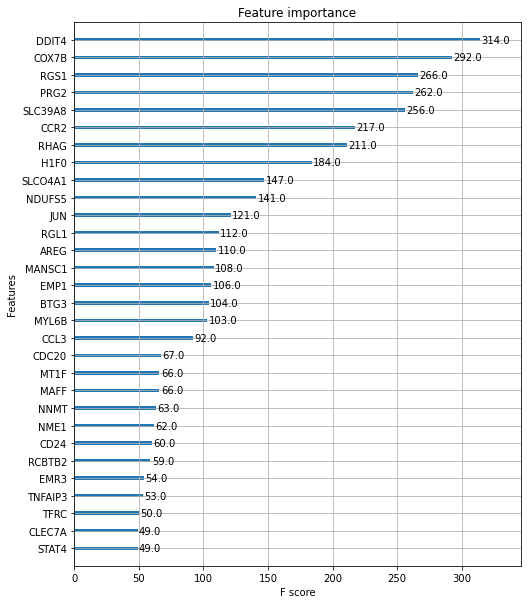

In [13]:
plot_importance(model,max_num_features=30)
plt.show()